In [192]:
import numpy as np
import imageio
import skimage.io as skio
import matplotlib.pyplot as plt
import json
import os


from scipy.interpolate import RegularGridInterpolator as grid_interpolator
from skimage.draw import polygon

In [7]:
def computeH(im1_pts,im2_pts):
    assert im1_pts.shape == im2_pts.shape, 'Points not in pair'

    A = []
    b = []
    for i in range(im1_pts.shape[0]):
        x, y = im1_pts[i]
        x_p, y_p = im2_pts[i]
        A.append([x, y, 1, 0, 0, 0, -1*x*x_p, -1*y*x_p])
        b.append([x_p])
        A.append([0, 0, 0, x, y, 1, -1*x*y_p, -1*y*y_p])
        b.append([y_p])
    A = np.array(A)
    b = np.array(b)

    H = np.linalg.inv(A.T @ A) @ A.T @ b

    return np.append(H, [1]).reshape(3,3)


In [428]:
def warpImage(im,H):
    inverse_trans = np.linalg.inv(H)

    h = im.shape[0]-1
    w = im.shape[1]-1

    y = np.arange(0, h+1)
    x = np.arange(0, w+1)

    R_interpolator = grid_interpolator((y, x), im[:, :, 0], bounds_error=False, fill_value=None)
    G_interpolator = grid_interpolator((y, x), im[:, :, 1], bounds_error=False, fill_value=None)
    B_interpolator = grid_interpolator((y, x), im[:, :, 2], bounds_error=False, fill_value=None)


    res_top_left = H @ [0,0,1] 
    res_top_left = (res_top_left/res_top_left[2])[:2][::-1]
    res_top_right = H @ [w,0,1] 
    res_top_right = (res_top_right/res_top_right[2])[:2][::-1]
    res_bottom_left = H @ [0,h,1]
    res_bottom_left = (res_bottom_left/res_bottom_left[2])[:2][::-1]
    res_bottom_right = H @ [w,h,1] 
    res_bottom_right = (res_bottom_right/res_bottom_right[2])[:2][::-1]
    res_corners = np.array([res_top_left, res_top_right, 
                        res_bottom_right, res_bottom_left])


    #  horizontal and vertical displacement of result image
    h_d = np.ceil((-1*np.min(res_corners[:,0]))).astype(int)
    v_d= np.ceil((-1*np.min(res_corners[:,1]))).astype(int)

    # result image height and width
    res_height = (np.max(res_corners[:,0]) - np.min(res_corners[:,0]) + 1).astype(int)
    res_width = (np.max(res_corners[:,1]) - np.min(res_corners[:,1]) + 1).astype(int)

    y_coords, x_coords = polygon(res_corners[:,0]+ h_d, 
                                 res_corners[:,1]+ v_d)

    res = np.zeros((res_height+1,res_width+1,3))

    one_s = [1]*x_coords.shape[0]

    des_points_ones = np.array([list(element) for element in zip(x_coords, y_coords, one_s)])

    src_points = np.array([(inverse_trans @ (point+[-v_d, -h_d, 0])) for point in des_points_ones])

    src_points = np.array([[point[0]/point[2],point[1]/point[2]][::-1] for point in src_points])

    res[y_coords,x_coords,0] = R_interpolator(src_points)
    res[y_coords,x_coords,1] = G_interpolator(src_points)
    res[y_coords,x_coords,2] = B_interpolator(src_points)

    return res, v_d, h_d

In [492]:
def align_and_blend(im_ori, im_trans, im_ori_pts, im_trans_pts, H, v_d, h_d):

    transformed_points = [H @ np.append(point, [1]) for point in im_trans_pts]
    transformed_points = np.array([(point/point[2])[:2].tolist() for point in transformed_points])

    align_pt1 = [np.mean(im_ori_pts[:,0]), np.mean(im_ori_pts[:,1])]
    align_pt2 = [np.mean(transformed_points[:,0])+v_d, np.mean(transformed_points[:,1])+h_d]

    y1, x1 = im_ori.shape[:2]
    y2, x2 = im_trans.shape[:2]

    offset_x = align_pt1[0]-align_pt2[0]
    offset_y = align_pt1[1]-align_pt2[1]

    width = np.round(max(x1, x2 + offset_x) - min(0, offset_x)).astype(int)
    height = np.round(max(y1, y2 + offset_y) - min(0, offset_y)).astype(int)

    ori_corner = np.round((0 - min(0, offset_x), 0 - min(0, offset_y))).astype(int)
    trans_corner = np.round((offset_x - min(0, offset_x), offset_y - min(0, offset_y))).astype(int)

    # finding mask
    canvas = np.zeros((height, width))
    canvas[ori_corner[1]:(ori_corner[1] + y1), ori_corner[0]:(ori_corner[0] + x1)] += 1
    ori_mask = canvas
    canvas = np.zeros((height, width))
    canvas[trans_corner[1]:(trans_corner[1] + y2),trans_corner[0]:(trans_corner[0] + x2)] +=1
    trans_mask = canvas
    intersection = np.where(ori_mask+trans_mask == 2, 1, 0).astype(float)

    rows, cols = np.where(intersection == 1)
    v_start = np.min(rows)
    v_end = np.max(rows)
    h_start = np.min(cols)
    h_end = np.max(cols)
    smooth_mask = np.linspace(0, 1, v_end-v_start+1).reshape(-1, 1)
    ori_mask[v_start:v_end+1,h_start:h_end+1] = np.tile(smooth_mask, (1, h_end-h_start+1))
    trans_mask[v_start:v_end+1,h_start:h_end+1] = np.tile(smooth_mask[::-1], (1, h_end-h_start+1))
    #

    syn1 = np.zeros((height, width, 3))
    syn2 = np.zeros((height, width, 3))

    syn1[ori_corner[1]:(ori_corner[1] + y1), ori_corner[0]:(ori_corner[0] + x1)] = im_ori
    syn2[trans_corner[1]:(trans_corner[1] + y2),trans_corner[0]:(trans_corner[0] + x2)] = im_trans

    final_res = syn1 * np.stack([ori_mask] * 3, axis=-1) + \
                syn2 * np.stack([trans_mask] * 3, axis=-1) 

    return final_res, ori_mask, trans_mask

In [446]:
# rectification

# campanile

campanile = skio.imread('./rectification/campanile.jpg')
with open('./rectification/campanile_campanile.json', 'r') as f:
    data = json.load(f)

campanile_pts = np.array([data['im1Points'], data['im2Points']])
campanile_pts[0]

array([[532, 747],
       [678, 710],
       [532, 888],
       [681, 855]])

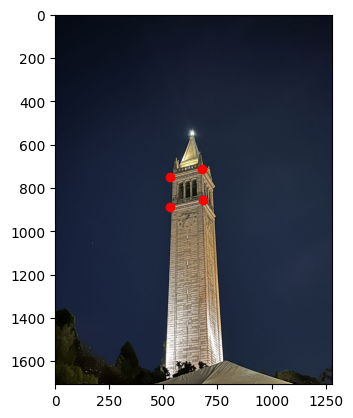

In [449]:
plt.imshow(campanile)
plt.scatter(campanile_pts[0][:,0], campanile_pts[0][:,1], color='red')

In [450]:
# hand annotated rectangle
campanile_pts[1] = np.array([[532, 747],
                     [678, 747],
                     [532, 888],
                     [678,888]])

In [451]:
H = computeH(campanile_pts[0], campanile_pts[1])
trans_campanile,_,_ = warpImage(campanile, H)

/Users/yilinni/anaconda3/envs/COMPSCI280/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


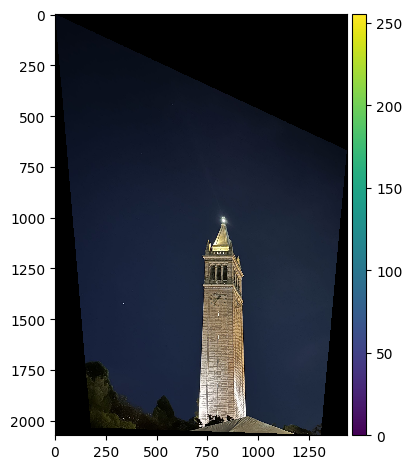

In [459]:
skio.imshow(trans_campanile.astype(int))
skio.imsave('./toWeb/trans_campanile.png', trans_campanile.astype(np.uint8))

[[ 530  474]
 [ 781  458]
 [ 780 1071]
 [ 528 1005]]


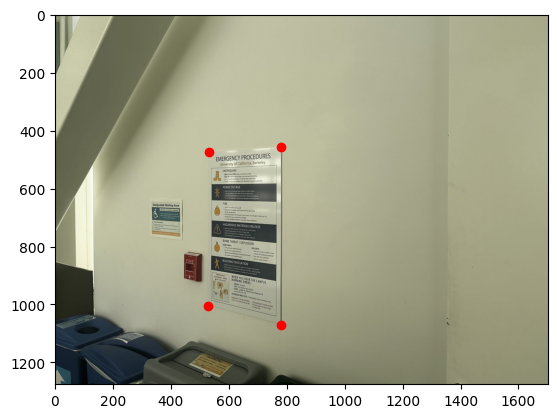

In [374]:
# poster 

poster = skio.imread('./rectification/poster.jpg')
with open('./rectification/poster_poster.json', 'r') as f:
    data = json.load(f)

poster_pts = np.array([data['im1Points'], data['im2Points']])
print(poster_pts[0])

plt.imshow(poster)
plt.scatter(poster_pts[0][:,0], poster_pts[0][:,1], color='red')

In [375]:
# hand annotated rectangle
poster_pts[1] = np.array([[530, 474],
                     [781, 474],
                     [781, 1071],
                     [530,1071]])

In [376]:
H = computeH(poster_pts[0], poster_pts[1])
trans_poster,_,_ = warpImage(poster, H)

In [456]:
trans_poster.shape

(2126, 1705, 3)

/Users/yilinni/anaconda3/envs/COMPSCI280/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


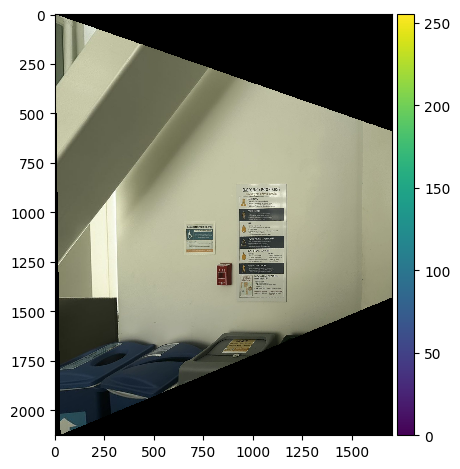

In [458]:
skio.imshow(trans_poster.astype(int))
skio.imsave('./toWeb/trans_poster.png', trans_poster.astype(np.uint8))

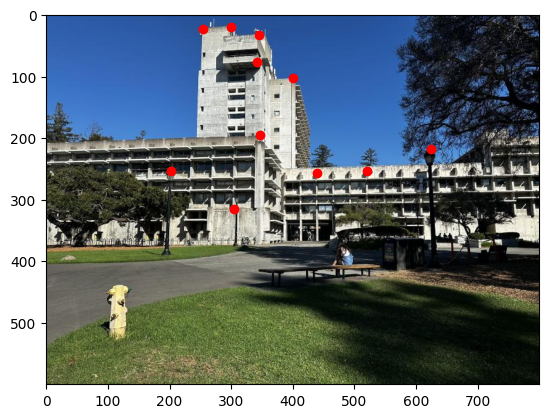

In [404]:
# Mosaic

# Wurster
wurster_center = skio.imread('./Wurster/wurster_center.jpg')
wurster_up = skio.imread('./Wurster/wurster_up.jpg')
with open('./Wurster/wurster_center_wurster_up.json', 'r') as f:
    data = json.load(f)

center_up_pts = [np.array(data['im1Points']), np.array(data['im2Points'])]

plt.imshow(wurster_center)
plt.scatter(center_up_pts[0][:,0], center_up_pts[0][:,1], color='red')

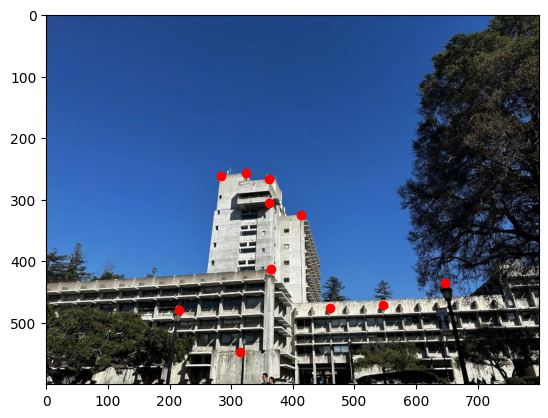

In [405]:
plt.imshow(wurster_up)
plt.scatter(center_up_pts[1][:,0], center_up_pts[1][:,1], color='red')

/Users/yilinni/anaconda3/envs/COMPSCI280/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


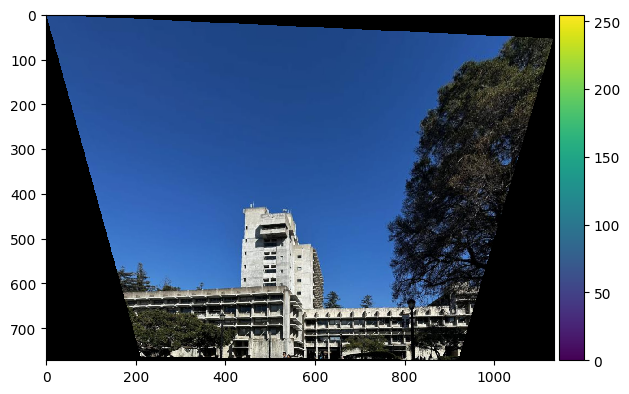

In [430]:
H_wurster = computeH(center_up_pts[1], center_up_pts[0])
trans_wurster,v_d_wurster, h_d_wurster = warpImage(wurster_up, H_wurster)
skio.imshow(trans_wurster.astype(int))

/Users/yilinni/anaconda3/envs/COMPSCI280/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


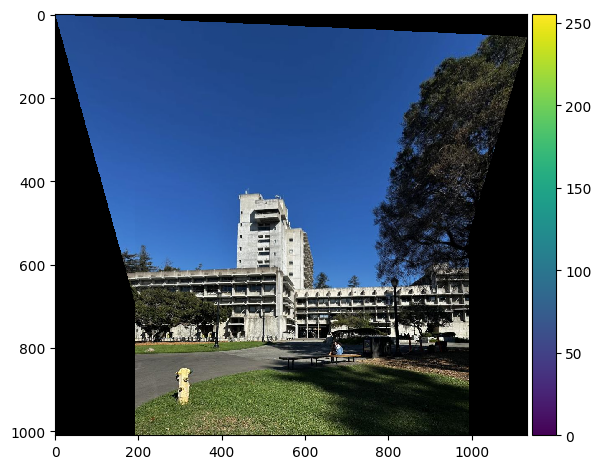

In [493]:
aligned_res,ori_mask,trans_mask = align_and_blend(wurster_center, trans_wurster , center_up_pts[0],\
                             center_up_pts[1], H_wurster, v_d_wurster, h_d_wurster)
skio.imshow(aligned_res.astype(int))
skio.imsave('./toWeb/trans_wurster.png', aligned_res.astype(np.uint8))

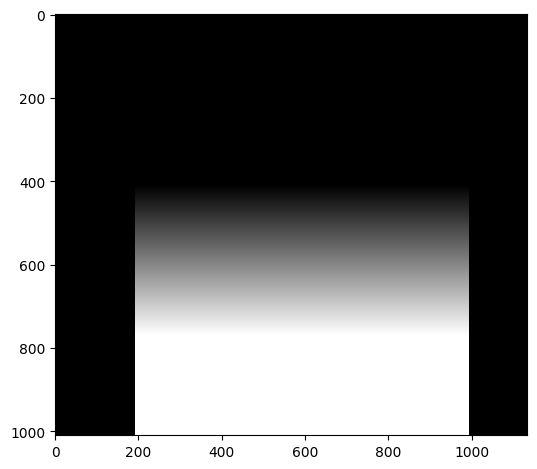

In [494]:
skio.imshow(ori_mask)

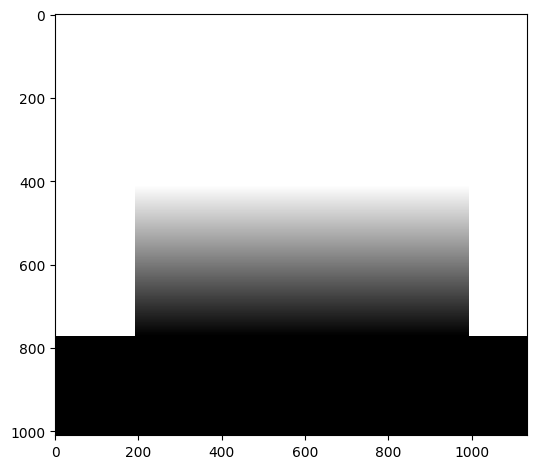

In [495]:
skio.imshow(trans_mask)

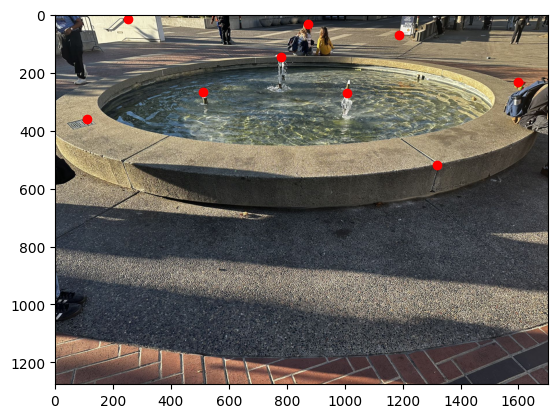

In [396]:
# Fountain
fountain_down = skio.imread('./Fountain/fountain_down.jpg')
fountain_up = skio.imread('./Fountain/fountain_up.jpg')
with open('./Fountain/fountain_down_fountain_up.json', 'r') as f:
    data = json.load(f)

fountain_pts = [np.array(data['im1Points']), np.array(data['im2Points'])]

plt.imshow(fountain_down)
plt.scatter(fountain_pts[0][:,0], fountain_pts[0][:,1], color='red')

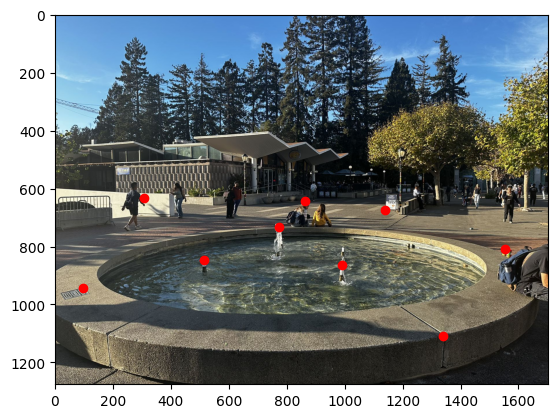

In [397]:
plt.imshow(fountain_up)
plt.scatter(center_up_pts[1][:,0], center_up_pts[1][:,1], color='red')

/Users/yilinni/anaconda3/envs/COMPSCI280/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


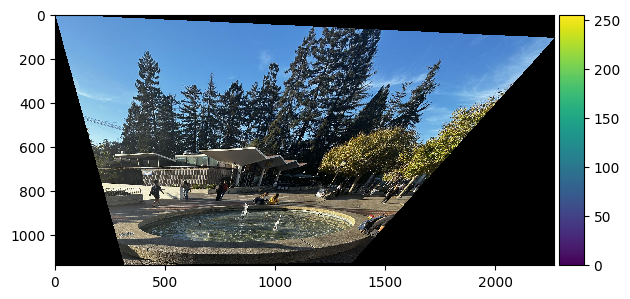

In [433]:
H_fountain = computeH(center_up_pts[1], center_up_pts[0])
trans_fountain,v_d_fountain,h_d_fountain = warpImage(fountain_up, H_fountain)
skio.imshow(trans_fountain.astype(int))

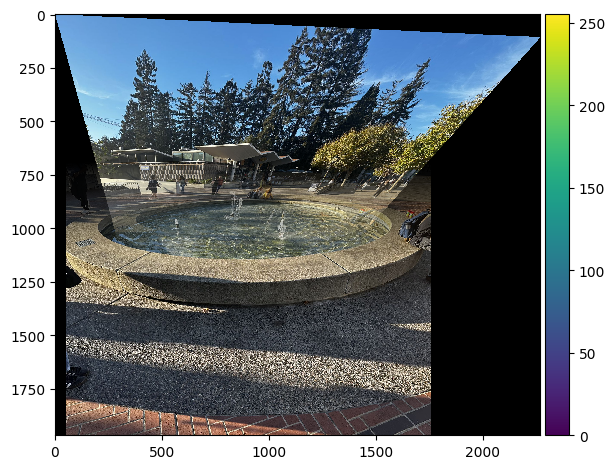

In [462]:

aligned_res = align_and_blend(fountain_down, trans_fountain, fountain_pts[0],\
                            fountain_pts[1], H_fountain, v_d_fountain, h_d_fountain)
skio.imshow(aligned_res.astype(int))
skio.imsave('./toWeb/trans_fountain.png', aligned_res.astype(np.uint8))

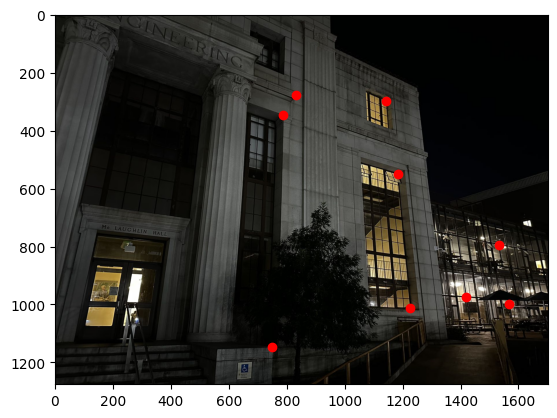

In [464]:
# EECS
EECS_left = skio.imread('./EECS/left.jpg')
EECS_right = skio.imread('./EECS/right.jpg')

with open('./EECS/left_right.json', 'r') as f:
    data = json.load(f)

EECS_pts = [np.array(data['im1Points']), np.array(data['im2Points'])]

plt.imshow(EECS_left)
plt.scatter(EECS_pts[0][:,0], EECS_pts[0][:,1], color='red')

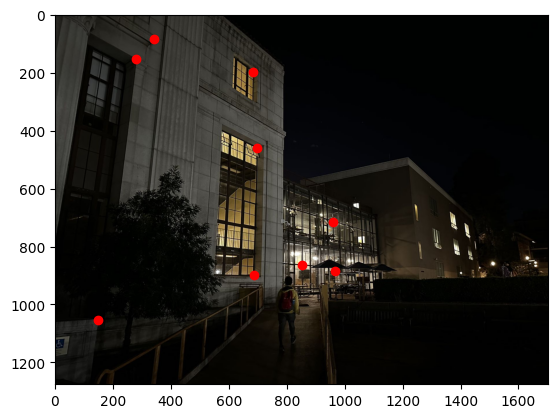

In [465]:
plt.imshow(EECS_right)
plt.scatter(EECS_pts[1][:,0], EECS_pts[1][:,1], color='red')

/Users/yilinni/anaconda3/envs/COMPSCI280/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


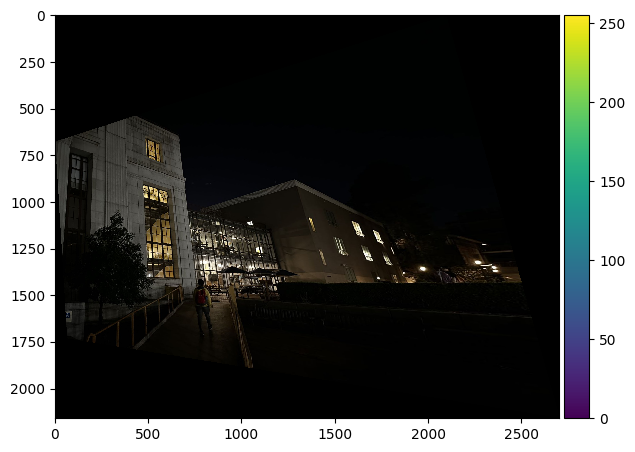

In [466]:
H_EECS = computeH(EECS_pts[1], EECS_pts[0])
trans_EECS,v_d_EECS, h_d_EECS = warpImage(EECS_right, H_EECS)
skio.imshow(trans_EECS.astype(int))

In [487]:
def align_and_blend(im_ori, im_trans, im_ori_pts, im_trans_pts, H, v_d, h_d):

    transformed_points = [H @ np.append(point, [1]) for point in im_trans_pts]
    transformed_points = np.array([(point/point[2])[:2].tolist() for point in transformed_points])

    align_pt1 = [np.mean(im_ori_pts[:,0]), np.mean(im_ori_pts[:,1])]
    align_pt2 = [np.mean(transformed_points[:,0])+v_d, np.mean(transformed_points[:,1])+h_d]

    y1, x1 = im_ori.shape[:2]
    y2, x2 = im_trans.shape[:2]

    offset_x = align_pt1[0]-align_pt2[0]
    offset_y = align_pt1[1]-align_pt2[1]

    width = np.round(max(x1, x2 + offset_x) - min(0, offset_x)).astype(int)
    height = np.round(max(y1, y2 + offset_y) - min(0, offset_y)).astype(int)

    ori_corner = np.round((0 - min(0, offset_x), 0 - min(0, offset_y))).astype(int)
    trans_corner = np.round((offset_x - min(0, offset_x), offset_y - min(0, offset_y))).astype(int)

    # finding mask
    canvas = np.zeros((height, width))
    canvas[ori_corner[1]:(ori_corner[1] + y1), ori_corner[0]:(ori_corner[0] + x1)] += 1
    ori_mask = canvas
    canvas = np.zeros((height, width))
    canvas[trans_corner[1]:(trans_corner[1] + y2),trans_corner[0]:(trans_corner[0] + x2)] +=1
    trans_mask = canvas
    intersection = np.where(ori_mask+trans_mask == 2, 1, 0).astype(float)

    rows, cols = np.where(intersection == 1)
    v_start = np.min(rows)
    v_end = np.max(rows)
    h_start = np.min(cols)
    h_end = np.max(cols)
    smooth_mask = np.linspace(0, 1, h_end-h_start+1)
    ori_mask[v_start:v_end+1,h_start:h_end+1] = np.tile(smooth_mask[::-1], (v_end-v_start+1,1 ))
    trans_mask[v_start:v_end+1,h_start:h_end+1] = np.tile(smooth_mask, (v_end-v_start+1,1))
    #

    syn1 = np.zeros((height, width, 3))
    syn2 = np.zeros((height, width, 3))

    syn1[ori_corner[1]:(ori_corner[1] + y1), ori_corner[0]:(ori_corner[0] + x1)] = im_ori
    syn2[trans_corner[1]:(trans_corner[1] + y2),trans_corner[0]:(trans_corner[0] + x2)] = im_trans

    final_res = syn1 * np.stack([ori_mask] * 3, axis=-1) + \
                syn2 * np.stack([trans_mask] * 3, axis=-1) 

    return final_res, ori_mask, trans_mask

/Users/yilinni/anaconda3/envs/COMPSCI280/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


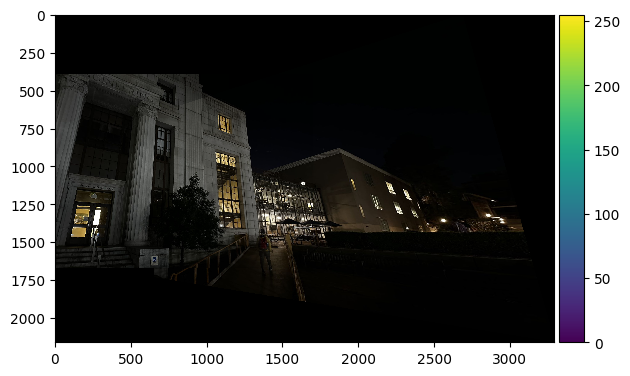

In [488]:
aligned_res,ori_mask, trans_mask = align_and_blend(EECS_left, trans_EECS, EECS_pts[0], EECS_pts[1],\
                             H_EECS, v_d_EECS, h_d_EECS)
skio.imshow(aligned_res.astype(int))

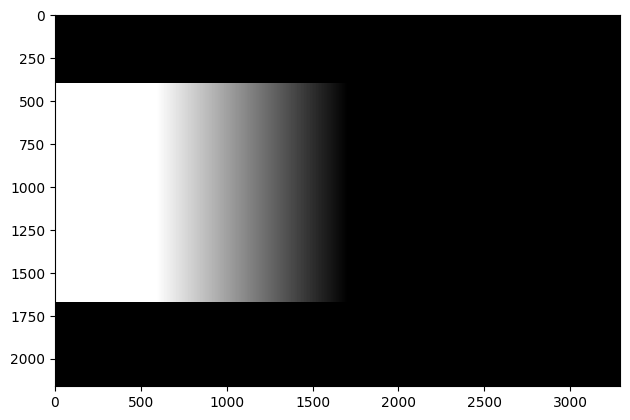

In [489]:
skio.imshow(ori_mask)

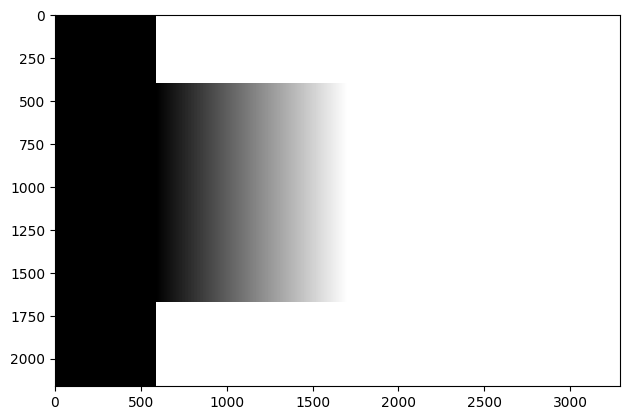

In [490]:
skio.imshow(trans_mask)

In [491]:
skio.imsave('./toWeb/trans_EECS.png', aligned_res.astype(np.uint8))

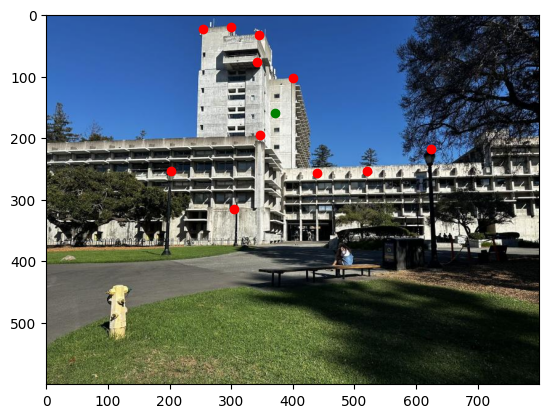

In [151]:
plt.imshow(wurster_center)
plt.scatter(center_up_pts[0][:,0], center_up_pts[0][:,1], color='red')
plt.scatter(np.mean(center_up_pts[0][:,0]), np.mean(center_up_pts[0][:,1]), color = 'green')

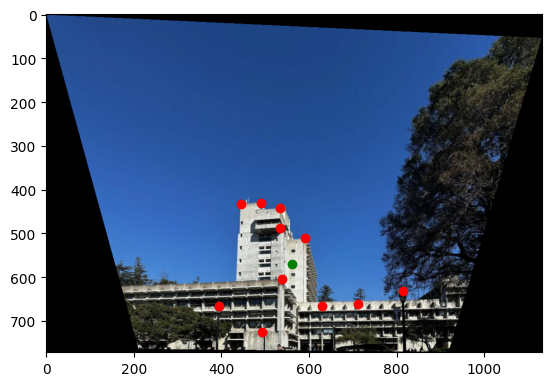

In [149]:
plt.imshow(res.astype(int))
plt.scatter(transformed_points[:,0]+v_d, transformed_points[:,1]+h_d,color='red')
plt.scatter(np.mean(transformed_points[:,0])+v_d, np.mean(transformed_points[:,1])+h_d, color = 'green')

In [345]:
aligned_res = align_and_blend(wurster_center, res, center_up_pts[0], center_up_pts[1], H_up_center)